## Let's create a dataset by downloading images from Bing

### Generate a dataframe from our dataset

In [11]:
import os
import pandas as pd
from glob import glob

DATA_DIR = "dataset_asl"
LETTERS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I' 'K']
data = []

for label_dir in os.listdir(DATA_DIR):
    if os.path.isfile(label_dir):
        continue
    
    label_path_path = os.path.join(DATA_DIR, label_dir)
    for file in os.listdir(label_path_path):
        data.append([os.path.join(label_path_path, file), label_dir])
        
dataframe = pd.DataFrame(data, columns = ["path", "label"])
dataframe

,path,label
0,dataset_asl\A\20220601_150845.jpg,A
1,dataset_asl\A\20220601_150851.jpg,A
2,dataset_asl\A\20220601_150951.jpg,A
3,dataset_asl\A\20220601_150955.jpg,A
4,dataset_asl\A\20220601_150956.jpg,A
...,...,...
96,dataset_asl\K\20220601_151333.jpg,K
97,dataset_asl\K\20220601_151336.jpg,K
98,dataset_asl\K\20220601_151339.jpg,K
99,dataset_asl\K\20220601_151341.jpg,K


### Show some images of the dataset

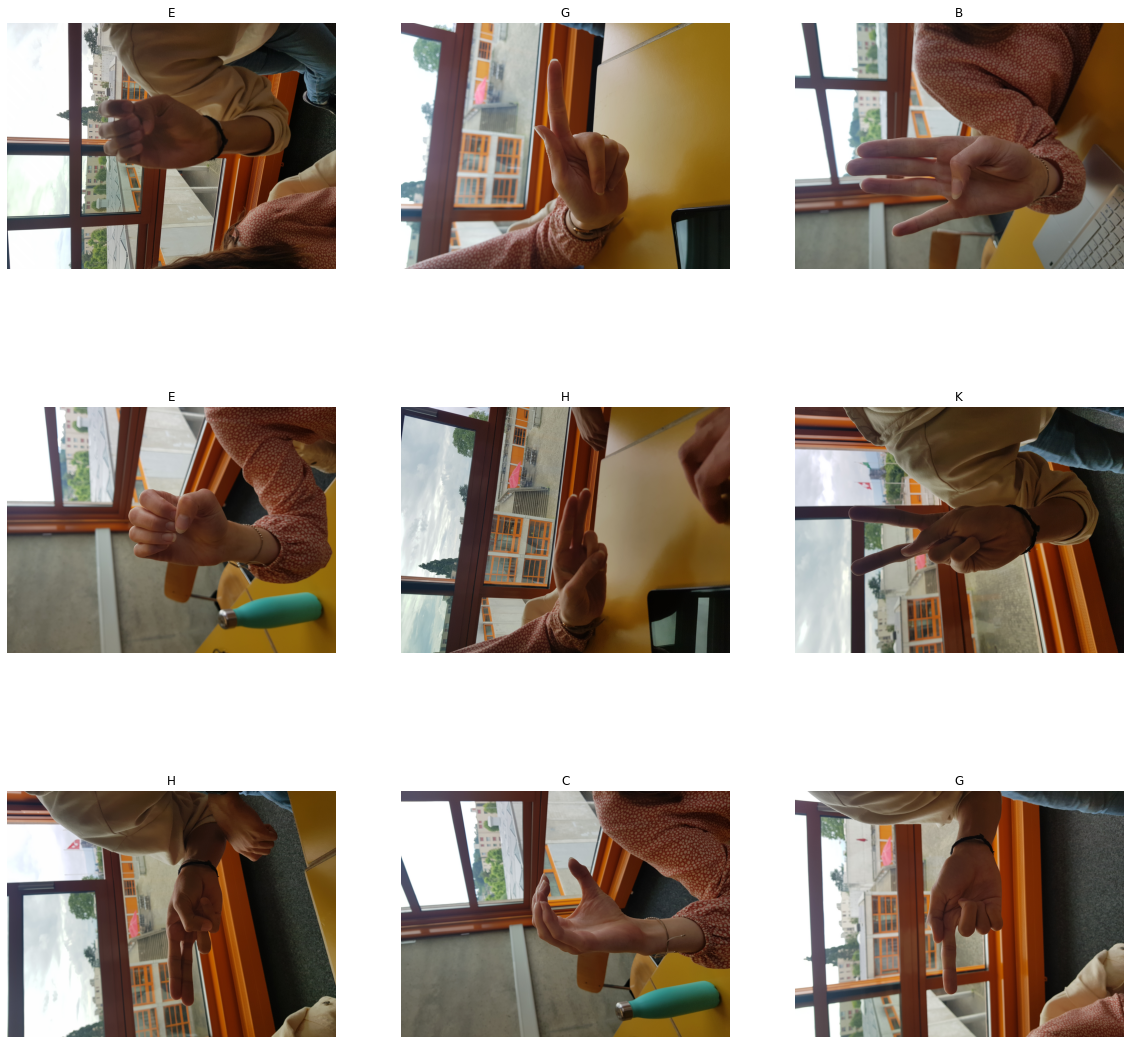

In [12]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image

 
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in dataframe.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

## Fetch MobileNetV2 model

In [13]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False # We don't want to include the fully-connected layers
)

In [14]:
# You can see the list of layers of this model
base_model.layers

In [15]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    Dropout
)

def get_model():
    # We want to add layers on top of the base (here MobileNetV2) model
    layers = base_model.output

    # We need to flatten
    layers = Flatten()(layers)

    # TODO: add some dense layers here
    layers = Dense(1024, activation = 'relu')(layers)
    

    # We must add an output layer
    output = Dense(len(LETTERS) + 1, activation='softmax')(layers) # final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=output)

    # TODO: freeze the base model layers (not the layers you've added obviously)
    # NOTE:
    # to feeze a layer you can set its trainable flag to False (e.g. layer.trainable = False)
    # to get a list of the model layers you can do model.layers

    for layer in model.layers[:155]:
        layer.trainable = False
    for layer in model.layers[155:]:
        layer.trainable = True
    
    model.compile(
      optimizer = RMSprop(),
      # Sparse categorical crossentropy is used when we have target class as integers
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [16]:
for i, layer in enumerate(get_model().layers):
    print (i, layer.name)

0 input_2
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [17]:
get_model().summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

## Cross validate model

In [18]:
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

In [19]:
def open_images(paths):
    images = []
    for path in paths:
        with PIL.Image.open(path) as image:
            images.append(image_preprocesses(np.asarray(image)))
            
    return np.array(images)

In [20]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = dataframe.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
CLASS_MAPPINGS = {
    'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'K':9
}

total_train_labels = np.array([CLASS_MAPPINGS[x] for x in total_train_labels])
test_labels = np.array([CLASS_MAPPINGS[x] for x in test_labels])

NB_EPOCHS = 4

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    train_images = open_images(total_train_paths[train_index])    
    train_labels = total_train_labels[train_index]
    
    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]
    
    model = get_model() # We reinitialize the model
    
    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

Epoch 1/4
2/2 [==============================] - 11s 4s/step - loss: 344.0690 - acc: 0.1094 - val_loss: 340.9380 - val_acc: 0.1875
Epoch 2/4
2/2 [==============================] - 4s 3s/step - loss: 215.7683 - acc: 0.3125 - val_loss: 121.9285 - val_acc: 0.5000
Epoch 3/4
2/2 [==============================] - 5s 3s/step - loss: 33.5342 - acc: 0.7812 - val_loss: 83.2527 - val_acc: 0.3125
Epoch 4/4
2/2 [==============================] - 5s 3s/step - loss: 0.0175 - acc: 0.9844 - val_loss: 68.0554 - val_acc: 0.3125
Epoch 1/4
2/2 [==============================] - 9s 4s/step - loss: 213.2316 - acc: 0.1719 - val_loss: 260.7246 - val_acc: 0.1875
Epoch 2/4
2/2 [==============================] - 5s 3s/step - loss: 139.7586 - acc: 0.4375 - val_loss: 57.2838 - val_acc: 0.5000
Epoch 3/4
2/2 [==============================] - 5s 3s/step - loss: 16.9009 - acc: 0.8594 - val_loss: 58.7147 - val_acc: 0.4375
Epoch 4/4
2/2 [==============================] - 5s 3s/step - loss: 0.9657 - acc: 0.9688 - val_lo

In [21]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name,k,n):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    pl.title(str(k)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()



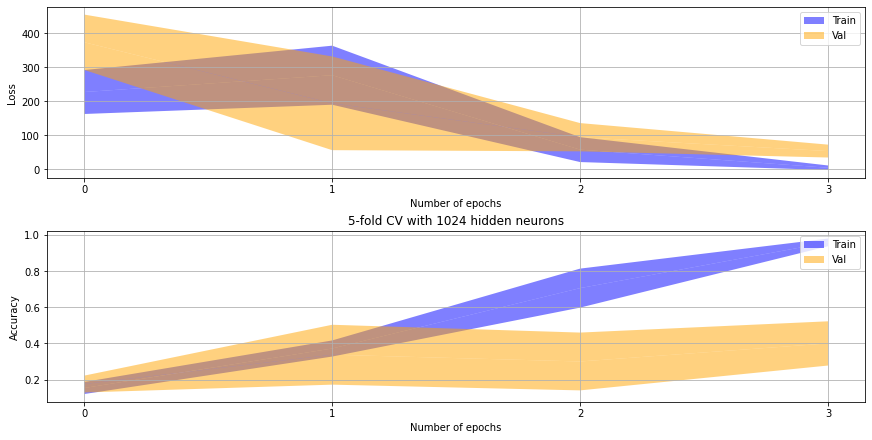

In [23]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss", 5, 1024)
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy", 5, 1024)

## Evaluate model on test set

In [24]:
# First retrain model on all the training data
train_images = open_images(total_train_paths)    
train_labels = total_train_labels

model = get_model() # We reinitialize the model

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=32,
    epochs=NB_EPOCHS,
)

Epoch 1/4
3/3 [==============================] - 9s 2s/step - loss: 254.0414 - acc: 0.1375
Epoch 2/4
3/3 [==============================] - 8s 2s/step - loss: 153.5659 - acc: 0.4750
Epoch 3/4
3/3 [==============================] - 7s 2s/step - loss: 16.7957 - acc: 0.8250
Epoch 4/4
3/3 [==============================] - 6s 2s/step - loss: 0.0900 - acc: 0.9875


In [25]:
# Empty a bit the memory
import gc

del train_images
del train_labels
gc.collect()

14141

In [27]:
import sklearn.metrics as me

test_images = open_images(test_paths)    

pred = model.predict(test_images)
pred = np.argmax(pred, axis=-1)

test_confusion_matrix = me.confusion_matrix(test_labels, pred, labels=np.arange(len(LETTERS)))

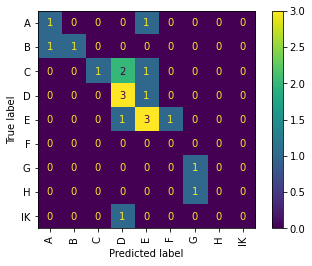

In [28]:
confusion_matrix_display = me.ConfusionMatrixDisplay(
    confusion_matrix=test_confusion_matrix,
    display_labels=LETTERS,
)

confusion_matrix_display.plot(xticks_rotation='vertical')
plt.show()